In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from triangle import triangulate, plot as tplot, convex_hull, show_data, get_data

from random import choice, sample
import matplotlib.colors as mcolors

In [2]:
t = np.linspace(0, 2*np.pi, 20, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T
seg = np.array([[j, j+1] for j in range(points.shape[0]-1)] + [[points.shape[0] - 1, 0]])

In [3]:
cndt = triangulate({"vertices":points, "segments":seg}, opts="Rpq30a0.01neo2")

In [4]:
# %matplotlib inline
# fig, ax = plt.subplots(figsize=(14, 14))
# ax = plt.subplot(111, aspect='equal')
# tplot(ax, **cndt)
# plt.show()

In [5]:
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
triangles_s = points[triangles]
triangles_c = triangles_s.reshape(-1, 2)

a = triangles_s[:, 0] - triangles_s[:, 1] 
b = triangles_s[:, 0] - triangles_s[:, 2] 
areas = np.abs(a[:, 0]*b[:, 1] - a[:, 1]*b[:, 0])

In [6]:
is_boundary_point = np.zeros(points.shape[0], dtype=bool)

In [7]:
for index, element in enumerate(triangles):
    
    if (neighbours[index] == -1).sum() >= 2:
        indices_ = np.where(neighbours[index] != -1)[0]
        is_boundary_point[element] = True
        
    elif (neighbours[index] == -1).sum() == 1:
        indices_ = np.where(neighbours[index] != -1)[0]
        is_boundary_point[element[indices_]] = True
        
        if (0 in indices_) and (1 in indices_):
            is_boundary_point[element[5]] = True
        
        if (1 in indices_) and (2 in indices_):
            is_boundary_point[element[3]] = True
        
        if (2 in indices_) and (0 in indices_):
            is_boundary_point[element[4]] = True

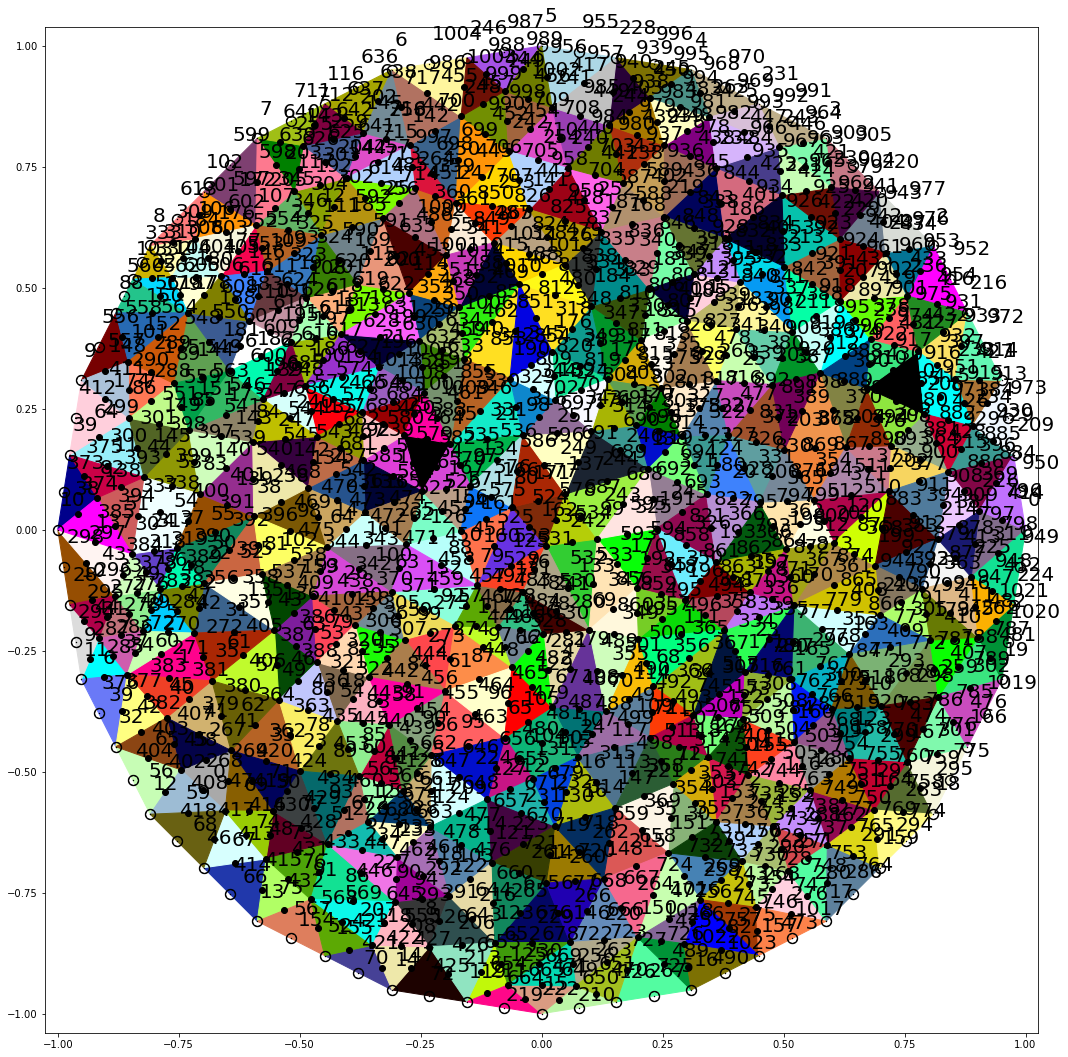

In [8]:
all_colors = list(mcolors.CSS4_COLORS.keys()) + list(mcolors.XKCD_COLORS.keys()) + list(mcolors.BASE_COLORS.keys())
all_colors = 10 * all_colors
colors = sample(all_colors, triangles_s.shape[0])

%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 15))
ax.axis("equal")

for index, triangle in enumerate(triangles_s[:]):
    t1 = plt.Polygon(triangle[:3], color=colors[index])
    fig.gca().add_patch(t1)
    
    x, y = triangle.mean(axis=0)
    ax.text(x, y, s=f"{index}", fontsize=20)

for idx, point in enumerate(points):
    ax.text(x=point[0]+0.005, y=point[1]+0.05, s=f"{idx}", fontsize=20)
    
for idx, point in enumerate(points):
    if is_boundary_point[idx]:
        ax.scatter(point[0], point[1], color="black", lw=10, s=2)
    else:
        ax.scatter(point[0], point[1], color="black")

ax.set_xlim([points[:, 0].min(), points[:, 0].max()])
ax.set_ylim([points[:, 1].min(), points[:, 1].max()])

fig.tight_layout()
plt.show()

In [9]:
matrix = np.zeros((points.shape[0], points.shape[0]), dtype=np.float32)
b = np.zeros(points.shape[0])
f = np.ones(points.shape[0])

for idx, element in enumerate(triangles):
        
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]
    
    # p_1
    if is_boundary_point[element[0]] == True:
        matrix[element[0], element[0]] = 1
        b[element[0]] *= 0
    else:
        #P_1 P_1
        matrix[element[0], element[0]] += 2 * 16 * (y2 - y3)**4 / areas[idx]**3
        matrix[element[0], element[0]] += 2 * 32 * (x2 - x3)**2 * (y2 - y3)**2 / areas[idx]**3
        matrix[element[0], element[0]] += 2 * 16 * (x2 - x3)**4 / areas[idx]**3
        #P_1 P_2
        matrix[element[0], element[1]] += 2 * 16 * (y1 - y3)**2 * (y2 - y3)**2 / areas[idx]**3
        matrix[element[0], element[1]] += 2 * 32 * (x1 - x3) * (x2 - x3) * (y1 - y3) * (y2 - y3) / areas[idx]**3
        matrix[element[0], element[1]] += 2 * 16 * (x1 - x3)**2 * (x2 - x3)**2 / areas[idx]**3
        #P_1 P_3
        matrix[element[0], element[2]] += 2 * 16 * (y1 - y2)**2 * (y2 - y3)**2 / areas[idx]**3
        matrix[element[0], element[2]] += 2 * 32 * (x1 - x2)*(x2 - x3)*(y1 - y2)*(y2 - y3) / areas[idx]**3
        matrix[element[0], element[2]] += 2 * 16 * (x1 - x2)**2 * (x2 - x3)**2 / areas[idx]**3
        #P_1 P_4
        matrix[element[0], element[3]] -= 2 * 32 * (y1 - y3) * (y2 - y3)**3 / areas[idx]**3
        matrix[element[0], element[3]] -= 2 * 32 * (x2 - x3) * (y2 - y3) * ((x1 - x3)*(y2 - y3) + (x2 - x3)*(y1 - y3)) / areas[idx]**3
        matrix[element[0], element[3]] -= 2 * 32 * (x1 - x3) * (x2 - x3)**3 / areas[idx]**3
        #P_1 P_5
        matrix[element[0], element[4]] -= 2 * 32 * (y1 - y2) * (y1 - y3) * (y2 - y3)**2 / areas[idx]**3
        matrix[element[0], element[4]] -= 2 * 32 * (x2 - x3) * (y2 - y3) * ((x1 - x2)*(y1 - y3) + (x1 - x3)*(y1 - y2)) / areas[idx]**3
        matrix[element[0], element[4]] -= 2 * 32 * (x1 - x2) * (x1 - x3) * (x2 - x3)**2 / areas[idx]**3
        #P_1 P_6
        matrix[element[0], element[5]] += 2 * 32 * (y1 - y2) * (y2 - y3)**3 / areas[idx]**3
        matrix[element[0], element[5]] += 2 * 32 * (x2 - x3) * (y2 - y3) * ((x1 - x2)*(y2 - y3) + (x2 - x3)*(y1 - y2)) / areas[idx]**3
        matrix[element[0], element[5]] += 2 * 32 * (x1 - x2) * (x2 - x3)**3 / areas[idx]**3
        
        b[element[0]] += 2 * areas[idx] / 3 * f[element[0]] * 0

        
    # p_2    
    if is_boundary_point[element[1]] == True:
        matrix[element[1], element[1]] = 1
        b[element[1]] *= 0
    else:
        #P_2 P_1
        matrix[element[1], element[0]] += 2 * 16 * (y1 - y3)**2 * (y2 - y3)**2 / areas[idx]**3
        matrix[element[1], element[0]] += 2 * 32 * (x1 - x3) * (x2 - x3) * (y1 - y3) * (y2 - y3) / areas[idx]**3
        matrix[element[1], element[0]] += 2 * 16 * (x1 - x3)**2 * (x2 - x3)**2 / areas[idx]**3
        #P_2 P_2
        matrix[element[1], element[1]] += 2 * 16 * (y1 - y3)**4 / areas[idx]**3
        matrix[element[1], element[1]] += 2 * 32 * (x1 - x3)**2 * (y1 - y3)**2 / areas[idx]**3
        matrix[element[1], element[1]] += 2 * 16 * (x1 - x3)**4 / areas[idx]**3
        #P_2 P_3
        matrix[element[1], element[2]] += 2 * 16 * (y1 - y2)**2 * (y1 - y3)**2 / areas[idx]**3
        matrix[element[1], element[2]] += 2 * 32 * (x1 - x2) * (x1 - x3) * (y1 - y2) * (y1 - y3) / areas[idx]**3
        matrix[element[1], element[2]] += 2 * 16 * (x1 - x2)**2 * (x1 - x3)**2 / areas[idx]**3
        #P_2 P_4
        matrix[element[1], element[3]] -= 2 * 32 * (y1 - y3)**3 * (y2 - y3) / areas[idx]**3
        matrix[element[1], element[3]] -= 2 * 32 * (x1 - x3) * (y1 - y3) * ((x1 - x3)*(y2 - y3) + (x2 - x3)*(y1 - y3)) / areas[idx]**3
        matrix[element[1], element[3]] -= 2 * 32 * (x1 - x3)**3 * (x2 - x3) / areas[idx]**3
        #P_2 P_5
        matrix[element[1], element[4]] -= 2 * 32 * (y1 - y2) * (y1 - y3)**3 / areas[idx]**3
        matrix[element[1], element[4]] -= 2 * 32 * (x1 - x3) * (y1 - y3) * ((x1 - x2)*(y1 - y3) + (x1 - x3)*(y1 - y2)) / areas[idx]**3
        matrix[element[1], element[4]] -= 2 * 32 * (x1 - x2) * (x1 - x3)**3 / areas[idx]**3
        #P_2 P_6
        matrix[element[1], element[5]] += 2 * 32 * (y1 - y2) * (y1 - y3)**2 * (y2 - y3) / areas[idx]**3
        matrix[element[1], element[5]] += 2 * 32 * (x1 - x3) * (y1 - y3) * ((x1 - x2)*(y2 - y3) + (x2 - x3)*(y1 - y2)) / areas[idx]**3
        matrix[element[1], element[5]] += 2 * 32 * (x1 - x2) * (x1 - x3)**2 * (x2 - x3) / areas[idx]**3


        b[element[1]] += 2 * areas[idx] / 3 * f[element[1]] * 0

        
    # p_3
    if is_boundary_point[element[2]] == True:
        matrix[element[2], element[2]] = 1
        b[element[2]] *= 0
    else:
        
        #P_3 P_1
        matrix[element[2], element[0]] += 2 * 16 * (y1 - y2)**2 * (y2 - y3)**2 / areas[idx]**3
        matrix[element[2], element[0]] += 2 * 32 * (x1 - x2) * (x2 - x3) * (y1 - y2) * (y2 - y3) / areas[idx]**3
        matrix[element[2], element[0]] += 2 * 16 * (x1 - x2)**2 * (x2 - x3)**2 / areas[idx]**3
        #P_3 P_2
        matrix[element[2], element[1]] += 2 * 16 * (y1 - y2)**2 * (y1 - y3)**2 / areas[idx]**3
        matrix[element[2], element[1]] += 2 * 32 * (x1 - x2) * (x1 - x3) * (y1 - y2) * (y1 - y3) / areas[idx]**3
        matrix[element[2], element[1]] += 2 * 16 * (x1 - x2)**2 * (x1 - x3)**2 / areas[idx]**3
        #P_3 P_3
        matrix[element[2], element[2]] += 2 * 16 * (y1 - y2)**4 / areas[idx]**3
        matrix[element[2], element[2]] += 2 * 32 * (x1 - x2)**2 * (y1 - y2)**2 / areas[idx]**3
        matrix[element[2], element[2]] += 2 * 16 * (x1 - x2)**4 / areas[idx]**3
        #P_3 P_4
        matrix[element[2], element[3]] -= 2 * 32 * (y1 - y2)**2 * (y1 - y3) * (y2 - y3)  / areas[idx]**3
        matrix[element[2], element[3]] -= 2 * 32 * (x1 - x2) * (y1 - y2) * ((x1 - x3) * (y2 - y3) + (x2 - x3) * (y1 - y3)) / areas[idx]**3
        matrix[element[2], element[3]] -= 2 * 32 * (x1 - x2)**2 * (x1 - x3) * (x2 - x3)  / areas[idx]**3
        #P_3 P_5
        matrix[element[2], element[4]] -= 2 * 32 * (y1 - y2)**3 * (y1 - y3)  / areas[idx]**3
        matrix[element[2], element[4]] -= 2 * 32 * (x1 - x2) * (y1 - y2) * ((x1 - x2) * (y1 - y3) + (x1 - x3) * (y1 - y2)) / areas[idx]**3#####
        matrix[element[2], element[4]] -= 2 * 32 * (x1 - x2)**3 * (x1 - x3)  / areas[idx]**3
        #P_3 P_6
        matrix[element[2], element[5]] += 2 * 32 * (y1 - y2)**3 * (y2 - y3)  / areas[idx]**3
        matrix[element[2], element[5]] += 2 * 32 * (x1 - x2) * (y1 - y2) * ((x1 - x2)*(y2 - y3) + (x2 - x3)*(y1 - y2)) / areas[idx]**3
        matrix[element[2], element[5]] += 2 * 32 * (x1 - x2)**3 * (x2 - x3)  / areas[idx]**3

        b[element[2]] += 2 * areas[idx] / 3 * f[element[2]] * 0

        
    # p_4
    if is_boundary_point[element[3]] == True:
        matrix[element[3], element[3]] = 1
        b[element[3]] *= 0
    else:
        
        #P_4 P_1
        matrix[element[3], element[0]] -= 2 * 32 * (y1 - y3) * (y2 - y3)**3 / areas[idx]**3
        matrix[element[3], element[0]] -= 2 * 32 * (x2 - x3) * (y2 - y3)*((x1 - x3)*(y2 - y3) + (x2 - x3)*(y1 - y3)) / areas[idx]**3
        matrix[element[3], element[0]] -= 2 * 32 * (x1 - x3) * (x2 - x3)**3 / areas[idx]**3
        #P_4 P_2
        matrix[element[3], element[1]] -= 2 * 32 * (y1 - y3)**3 * (y2 - y3) / areas[idx]**3
        matrix[element[3], element[1]] -= 2 * 32 * (x1 - x3)*(y1 - y3)*((x1 - x3)*(y2 - y3) + (x2 - x3)*(y1 - y3)) / areas[idx]**3
        matrix[element[3], element[1]] -= 2 * 32 * (x1 - x3)**3 * (x2 - x3) / areas[idx]**3
        #P_4 P_3
        matrix[element[3], element[2]] -= 2 * 32 * (y1 - y2)**2 * (y1 - y3) * (y2 - y3) / areas[idx]**3
        matrix[element[3], element[2]] -= 2 * 32 * (x1 - x2)*(y1 - y2)*((x1 - x3)*(y2 - y3) + (x2 - x3)*(y1 - y3)) / areas[idx]**3####
        matrix[element[3], element[2]] -= 2 * 32 * (x1 - x2)**2 * (x1 - x3) * (x2 - x3) / areas[idx]**3
        #P_4 P_4
        matrix[element[3], element[3]] += 2 * 64 * (y1 - y3)**2 * (y2 - y3)**2 / areas[idx]**3
        matrix[element[3], element[3]] += 2 * 32 * ((x1 - x3)*(y2 - y3) + (x2 - x3)*(y1 - y3))**2 / areas[idx]**3
        matrix[element[3], element[3]] += 2 * 64 * (x1 - x3)**2 * (x2 - x3)**2 / areas[idx]**3
        #P_4 P_5
        matrix[element[3], element[4]] += 2 * 64 * (y1 - y2) * (y1 - y3)**2 * (y2 - y3) / areas[idx]**3
        matrix[element[3], element[4]] += 2 * 32 * ((x1 - x2)*(y1 - y3) + (x1 - x3)*(y1 - y2))*((x1 - x3)*(y2 - y3) + (x2 - x3)*(y1 - y3)) / areas[idx]**3
        matrix[element[3], element[4]] += 2 * 64 * (x1 - x2) * (x1 - x3)**2 * (x2 - x3) / areas[idx]**3
        #P_4 P_6
        matrix[element[3], element[5]] -= 2 * 64 * (y1 - y2) * (y1 - y3) * (y2 - y3)**2 / areas[idx]**3
        matrix[element[3], element[5]] -= 2 * 32 * ((x1 - x2)*(y2 - y3) + (x2 - x3)*(y1 - y2))*((x1 - x3)*(y2 - y3) + (x2 - x3)*(y1 - y3)) / areas[idx]**3
        matrix[element[3], element[5]] -= 2 * 64 * (x1 - x2) * (x1 - x3) * (x2 - x3)**2 / areas[idx]**3


        b[element[3]] += 2 * areas[idx] / 3 * f[element[3]]

        
    # p_5
    if is_boundary_point[element[4]] == True:
        matrix[element[4], element[4]] = 1
        b[element[4]] *= 0
    else:
        
        #P_5 P_1
        matrix[element[4], element[0]] -= 2 * 32 * (y1 - y2) * (y1 - y3) * (y2 - y3)**2 / areas[idx]**3####
        matrix[element[4], element[0]] -= 2 * 32 * (x2 - x3) * (y2 - y3) * ((x1 - x2)*(y1 - y3) + (x1 - x3)*(y1 - y2)) / areas[idx]**3
        matrix[element[4], element[0]] -= 2 * 32 * (x1 - x2) * (x1 - x3) * (x2 - x3)**2/ areas[idx]**3####
        #P_5 P_2
        matrix[element[4], element[1]] -= 2 * 32 * (y1 - y2) * (y1 - y3)**3 / areas[idx]**3
        matrix[element[4], element[1]] -= 2 * 32 * (x1 - x3) * (y1 - y3) * ((x1 - x2)*(y1 - y3) + (x1 - x3)*(y1 - y2)) / areas[idx]**3
        matrix[element[4], element[1]] -= 2 * 32 * (x1 - x2) * (x1 - x3)**3 / areas[idx]**3
        #P_5 P_3
        matrix[element[4], element[2]] -= 2 * 32 * (y1 - y2)**3 * (y1 - y3) / areas[idx]**3
        matrix[element[4], element[2]] -= 2 * 32 * (x1 - x2) * (y1 - y2) * ((x1 - x2)*(y1 - y3) + (x1 - x3)*(y1 - y2)) / areas[idx]**3
        matrix[element[4], element[2]] -= 2 * 32 * (x1 - x2)**3 * (x1 - x3) / areas[idx]**3
        #P_5 P_4
        matrix[element[4], element[3]] += 2 * 64 * (y1 - y2) * (y1 - y3)**2 * (y2 - y3) / areas[idx]**3
        matrix[element[4], element[3]] += 2 * 32 * ((x1 - x2)*(y1 - y3) + (x1 - x3)*(y1 - y2)) * ((x1 - x3)*(y2 - y3) + (x2 - x3)*(y1 - y3)) / areas[idx]**3
        matrix[element[4], element[3]] += 2 * 64 * (x1 - x2) * (x1 - x3)**2 * (x2 - x3) / areas[idx]**3
        #P_5 P_5
        matrix[element[4], element[4]] += 2 * 64 * (y1 - y2)**2 * (y1 - y3)**2 / areas[idx]**3
        matrix[element[4], element[4]] += 2 * 32 * ((x1 - x2)*(y1 - y3) + (x1 - x3)*(y1 - y2))**2 / areas[idx]**3
        matrix[element[4], element[4]] += 2 * 64 * (x1 - x2)**2 * (x1 - x3)**2 / areas[idx]**3
        #P_5 P_6
        matrix[element[4], element[5]] -= 2 * 64 * (y1 - y2)**2 * (y1 - y3) * (y2 - y3) / areas[idx]**3
        matrix[element[4], element[5]] -= 2 * 32 * ((x1 - x2)*(y1 - y3) + (x1 - x3)*(y1 - y2)) * ((x1 - x2)*(y2 - y3) + (x2 - x3)*(y1 - y2)) / areas[idx]**3
        matrix[element[4], element[5]] -= 2 * 64 * (x1 - x2)**2 * (x1 - x3) * (x2 - x3) / areas[idx]**3

        b[element[4]] += 2 * areas[idx] / 3 * f[element[4]]


    # p_6
    if is_boundary_point[element[5]] == True:
        matrix[element[5], element[5]] = 1
        b[element[5]] *= 0
    else:
        
        #P_6 P_1
        matrix[element[5], element[0]] += 2 * 32 * (y1 - y2) * (y2 - y3)**3 / areas[idx]**3
        matrix[element[5], element[0]] += 2 * 32 * (x2 - x3) * (y2 - y3) * ((x1 - x2)*(y2 - y3) + (x2 - x3)*(y1 - y2)) / areas[idx]**3
        matrix[element[5], element[0]] += 2 * 32 * (x1 - x2) * (x2 - x3)**3 / areas[idx]**3
        #P_6 P_2
        matrix[element[5], element[1]] += 2 * 32 * (y1 - y2) * (y1 - y3)**2 * (y2 - y3) / areas[idx]**3
        matrix[element[5], element[1]] += 2 * 32 * (x1 - x3) * (y1 - y3) * ((x1 - x2)*(y2 - y3) + (x2 - x3)*(y1 - y2)) / areas[idx]**3
        matrix[element[5], element[1]] += 2 * 32 * (x1 - x2) * (x1 - x3)**2 * (x2 - x3) / areas[idx]**3        
        #P_6 P_3
        matrix[element[5], element[2]] += 2 * 32 * (y1 - y2)**3 * (y2 - y3) / areas[idx]**3
        matrix[element[5], element[2]] += 2 * 32 * (x1 - x2) * (y1 - y2) * ((x1 - x2)*(y2 - y3) + (x2 - x3)*(y1 - y2)) / areas[idx]**3
        matrix[element[5], element[2]] += 2 * 32 * (x1 - x2)**3 * (x2 - x3) / areas[idx]**3
        #P_6 P_4
        matrix[element[5], element[3]] -= 2 * 64 * (y1 - y2) * (y1 - y3) * (y2 - y3)**2 / areas[idx]**3
        matrix[element[5], element[3]] -= 2 * 32 * ((x1 - x2)*(y2 - y3) + (x2 - x3)*(y1 - y2)) * ((x1 - x3)*(y2 - y3) + (x2 - x3)*(y1 - y3)) / areas[idx]**3
        matrix[element[5], element[3]] -= 2 * 64 * (x1 - x2) * (x1 - x3) * (x2 - x3)**2 / areas[idx]**3        
        #P_6 P_5
        matrix[element[5], element[4]] -= 2 * 64 * (y1 - y2)**2 * (y1 - y3) * (y2 - y3) / areas[idx]**3
        matrix[element[5], element[4]] -= 2 * 32 * ((x1 - x2)*(y1 - y3) + (x1 - x3)*(y1 - y2)) * ((x1 - x2)*(y2 - y3) + (x2 - x3)*(y1 - y2)) / areas[idx]**3
        matrix[element[5], element[4]] -= 2 * 64 * (x1 - x2)**2 * (x1 - x3) * (x2 - x3) / areas[idx]**3        
        #P_6 P_6
        matrix[element[5], element[5]] += 2 * 64 * (y1 - y2)**2 * (y2 - y3)**2 / areas[idx]**3
        matrix[element[5], element[5]] += 2 * 32 * ((x1 - x2)*(y2 - y3) + (x2 - x3)*(y1 - y2))**2 / areas[idx]**3
        matrix[element[5], element[5]] += 2 * 64 * (x1 - x2)**2 * (x2 - x3)**2 / areas[idx]**3        
        
        b[element[5]] += 2 * areas[idx] / 3 * f[element[5]]

In [10]:
c = np.linalg.solve(matrix, b)
# print(c.min(), c.max(), sep="\n")

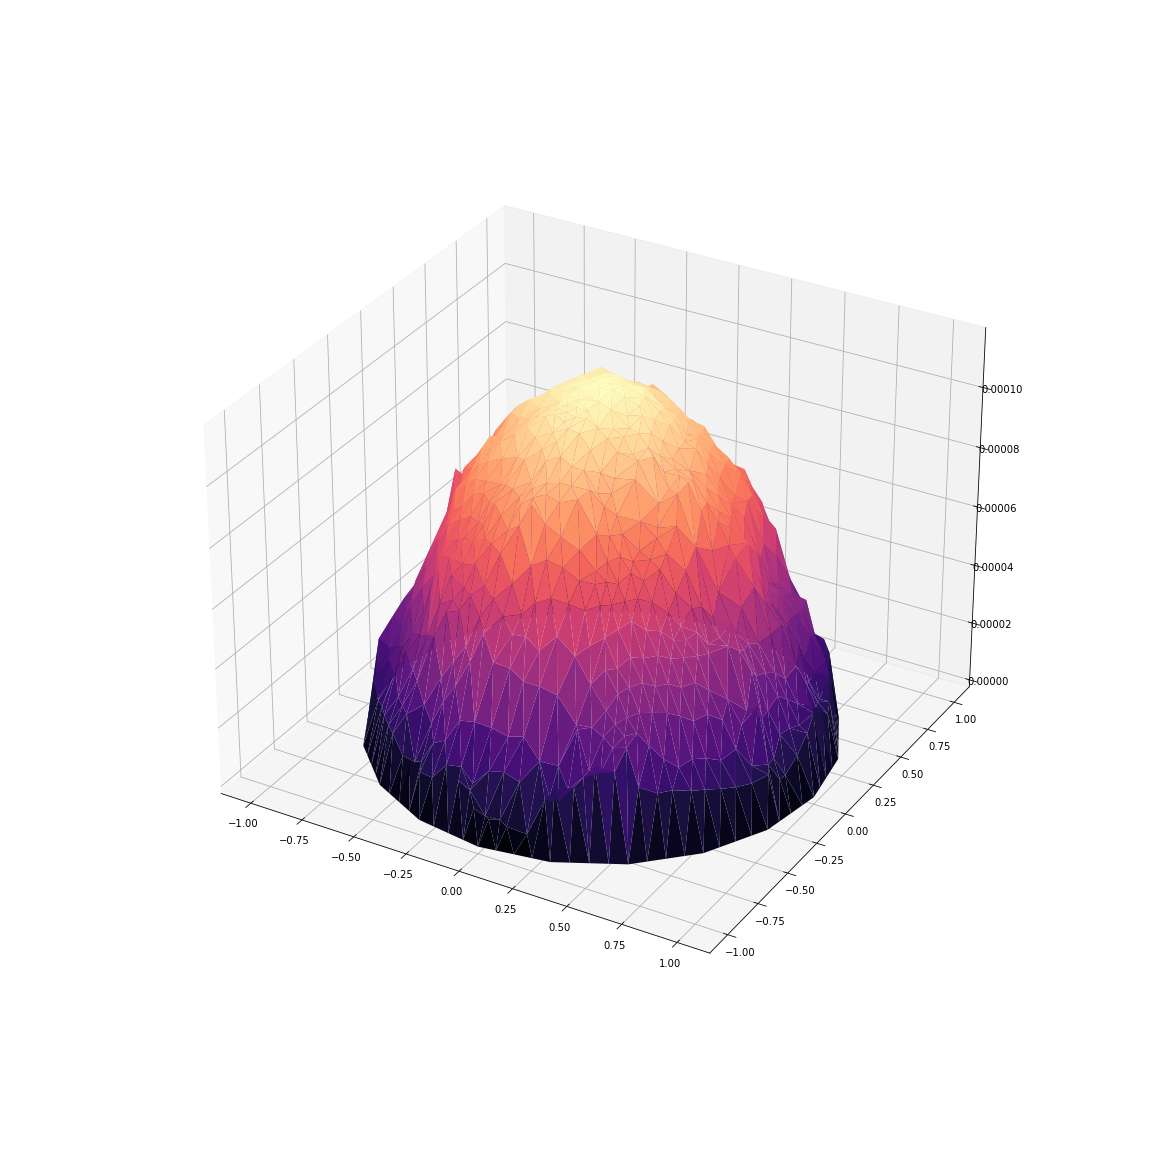

In [13]:
%matplotlib widget
fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection='3d')
# ax.plot_surface(xx, yy, S, color='blue')
# ax.plot_wireframe(xx, yy, S, color="black")
# ax.scatter(points[:, 0], points[:, 1], c, color="red")

# ax.set_box_aspect((np.ptp(points[:, 0]), np.ptp(points[:, 1]), 1000 * np.ptp(c)))
ax.plot_trisurf(points[:, 0], points[:, 1], c, cmap="magma")
# ax.plot_trisurf(points[:, 0], points[:, 1], (1-points[:, 0]**2-points[:, 1]**2)**2/64)
plt.show()

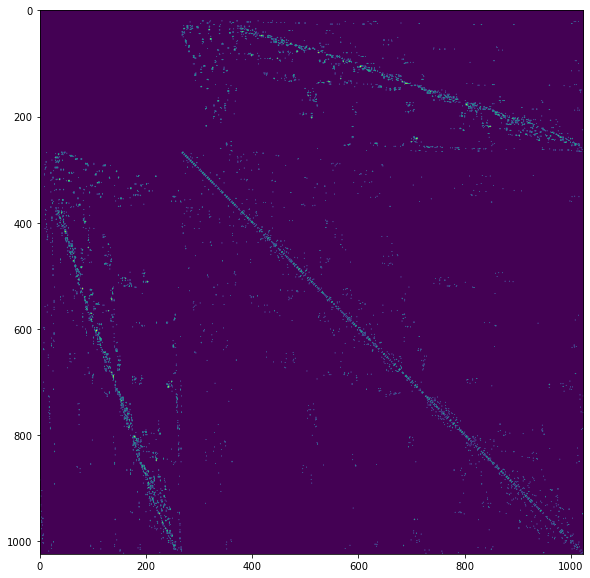

In [12]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(matrix < 0)
plt.show()